In [1]:
# Uncomment the lines below in case the following packages are not installed: 

#!pip3 install humanfriendly
#!pip3 install queue
#!pip3 install tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from humanfriendly import format_timespan
from collections import deque
from tqdm.notebook import tqdm

plt.style.use('seaborn-whitegrid')
pd.options.display.max_columns = None

### 1. Exploratory Data Analysis

In [3]:
df = pd.read_csv('Cell_a.csv')

df.head()

,Job_ID,Task_ID,Arrival_Time,CPU,Memory
0,375000667413,0,603026300,0.041851,0.001169
1,375000669289,0,606413041,0.024968,0.001179
2,375000670586,0,608994453,0.024176,0.001173
3,375000670588,0,608994466,0.019552,0.001163
4,375000670590,0,609042903,0.028044,0.001179


Number of tasks in our dataset:

In [4]:
len(df)

2329133

Number of Jobs in our dataset:

In [5]:
len(df.groupby('Arrival_Time')['Job_ID'].nunique())

1163061

In [6]:
# 1. Maximum and Minimum CPU/Memory Requirements
max_cpu = df['CPU'].max()
min_cpu = df['CPU'].min()
max_memory = df['Memory'].max()
min_memory = df['Memory'].min()

print(f"Max CPU: {max_cpu}, Min CPU: {min_cpu}, Max Memory: {max_memory}, Min Memory: {min_memory}", end='\n\n')

# 2. Average CPU/Memory Requirements
avg_cpu = df['CPU'].mean()
avg_memory = df['Memory'].mean()

print(f"Average CPU: {avg_cpu}, Average Memory: {avg_memory}", end='\n\n')

# 3. Median CPU/Memory Requirements
median_cpu = df['CPU'].median()
median_memory = df['Memory'].median()

print(f"Median CPU: {median_cpu}, Median Memory: {median_memory}", end='\n\n')

# 4. Task Arrival Pattern
# calculate the differences between consecutive arrival times to get the arrival intervals
arrival_intervals = df['Arrival_Time'].diff()
avg_arrival_interval = arrival_intervals.mean()

print(f"Average Arrival Interval: {avg_arrival_interval}", end='\n\n')

# 5. Correlation between CPU and Memory Requirements
correlation = df['CPU'].corr(df['Memory'])

print(f"Correlation between CPU and Memory: {correlation}", end='\n\n')

Max CPU: 52787.07165527344, Min CPU: 0.0, Max Memory: 0.41064453125, Min Memory: 0.0

Average CPU: 3.9625833591509836, Average Memory: 0.001497996789473209

Median CPU: 0.072418212890625, Median Memory: 0.000868797302246

Average Arrival Interval: 1149941.6237898925

Correlation between CPU and Memory: 0.0823307029366524



From the correlation metric above, we can see that tasks with high demands of CPU do not necessarily also require high amounts of memory to be processed.

In [7]:
# 6. Correlation between CPU and Memory Requirements
duplicates = df.groupby('Arrival_Time')['Job_ID'].nunique().max()

if duplicates == 1:
    print("No jobs with the same Arrival Time")
else:
    print("We have some jobs with the same Arrival Time")

No jobs with the same Arrival Time


Every job is received at a different arrival time. When that happens, each task belonging to that job is spawned at the exact same time (see the example below):

In [8]:
df[df['Job_ID'] == 375072287691]

,Job_ID,Task_ID,Arrival_Time,CPU,Memory
19994,375072287691,0,23939145045,0.000000,0.000005
19995,375072287691,1,23939145045,0.000685,0.000033


Now we want to make sure that our dataframe is actually sorted by the arrival times, otherwise our implementation will be meaningless

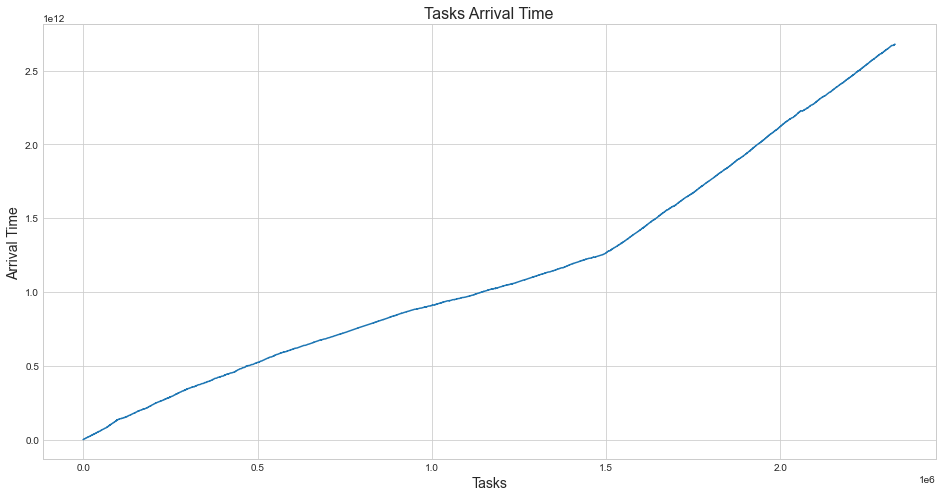

In [9]:
# 7. Make sure that the arrival times in the dataframe are actually sorted
df.sort_values('Arrival_Time', inplace=True)

fig = plt.subplots(figsize=(16, 8))

ax = df['Arrival_Time'].plot()

ax.set_xlabel('Tasks', fontsize=14)
ax.set_ylabel('Arrival Time', fontsize=14)
ax.set_title('Tasks Arrival Time', fontsize=16)

plt.show()

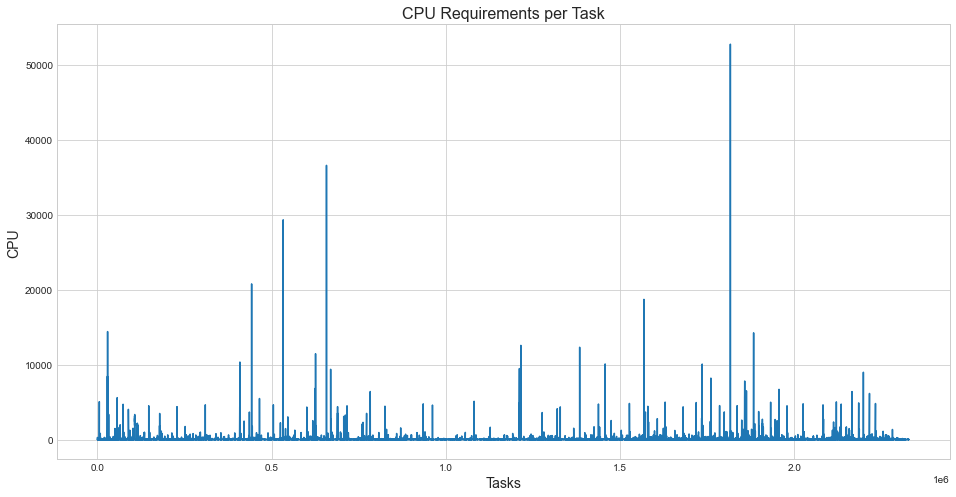

In [10]:
# 8. Check the amount of CPU required by each Task, so to locate potential outliers

fig = plt.subplots(figsize=(16, 8))

ax = df['CPU'].plot()

ax.set_xlabel('Tasks', fontsize=14)
ax.set_ylabel('CPU', fontsize=14)
ax.set_title('CPU Requirements per Task', fontsize=16)

plt.show()

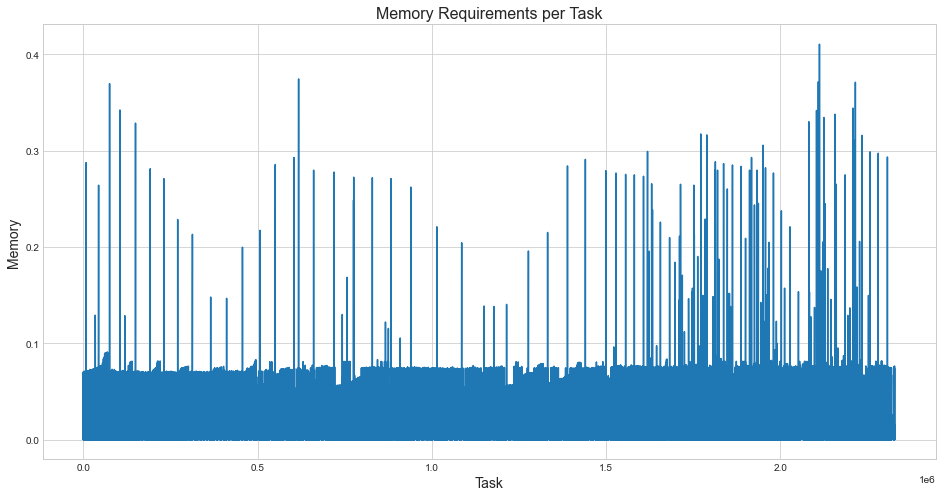

In [11]:
# 9. Check the amount of Memory required by each Task, so to locate potential outliers

fig = plt.subplots(figsize=(16, 8))

ax = df['Memory'].plot()

ax.set_xlabel('Task', fontsize=14)
ax.set_ylabel('Memory', fontsize=14)
ax.set_title('Memory Requirements per Task', fontsize=16)

plt.show()

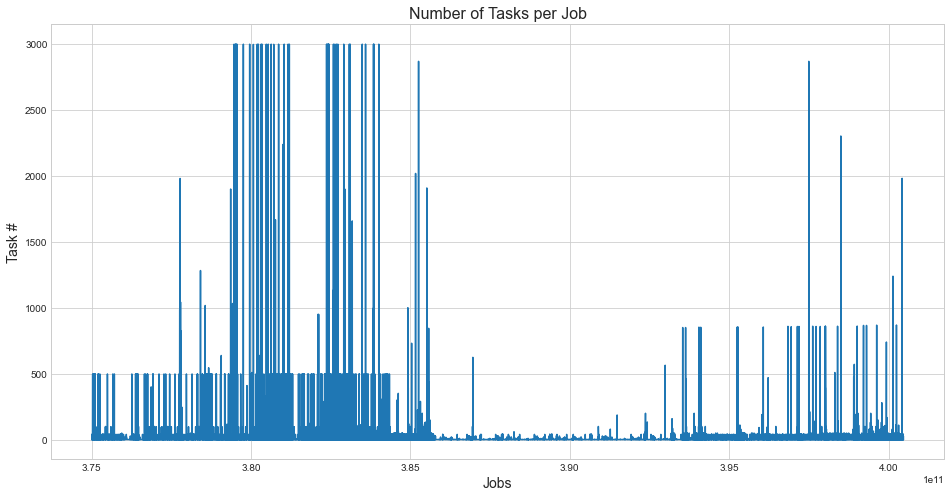

In [12]:
# 10. Check how many Tasks each Job requires
tasks_per_job = df.groupby('Job_ID')['Task_ID'].count()

fig = plt.subplots(figsize=(16, 8))

ax = tasks_per_job.plot()

ax.set_xlabel('Jobs', fontsize=14)
ax.set_ylabel('Task #', fontsize=14)
ax.set_title('Number of Tasks per Job', fontsize=16)

plt.show()

In [13]:
print(f'Mean number of tasks per job: {tasks_per_job.mean()}')

Mean number of tasks per job: 2.002588858194024


In [14]:
print(f'Median number of tasks per job: {tasks_per_job.median()}')

Median number of tasks per job: 1.0


### 2. Job Dispatching and Server Scheduling algorithms in Action

In [15]:
# Initialize parameters
N = 64
mu = 0.1
GNCU = round(df["CPU"].max()) + 1
GNMU = 1

np.random.seed(123)

In [16]:
# Initialize a dictionary to store the server status for each server
custom_server_status = {i: {'unfinished_work': 0, 'first_arrival_time': 0, 'last_arrival_time': 0, 'memory': GNMU, 'cpu': GNCU, 'tasks': []} for i in range(1, N + 1)}

# Initialize a dictionary to store the task service times
custom_task_service_times = {}

# Initialize a dictionary to store the task response times
custom_task_response_times = {}

# Initialize a dictionary to store the amount of messages of each task
custom_task_messaging_load = {}

# Initialize a dictionary to store the job response times for each server
server_response_times = {i: [] for i in range(1, N + 1)}

# Initialize a task queue
task_queue = deque()


def choose_server(servers_loads):  
    min_value = min(servers_loads.values())
    min_keys = [key for key, value in servers_loads.items() if value == min_value]

    chosen_server = np.random.choice(min_keys)

    return chosen_server


def scheduling_algorithm(job_id, task_id, arrival_time, cpu, memory, chosen_server):

    # Here we implement the SRTF scheduling algorithm to schedule the task on the chosen server
    
    # convert from microseconds to seconds
    arrival_time = arrival_time / 1000000
    
    service_time = (cpu / mu) / 1000
    
    # Initialize job trackers
    if job_id not in custom_task_service_times:
        custom_task_service_times[job_id] = []
        custom_task_response_times[job_id] = []
        
    # Register the arrival of the first task for this server
    if not custom_server_status[chosen_server]['first_arrival_time']:
        custom_server_status[chosen_server]['first_arrival_time'] = arrival_time
        
    # Update the server status
    custom_server_status[chosen_server]['unfinished_work'] += service_time
    custom_server_status[chosen_server]['memory'] -= memory
    custom_server_status[chosen_server]['cpu'] -= cpu
    custom_server_status[chosen_server]['last_arrival_time'] = arrival_time + service_time
    custom_server_status[chosen_server]['tasks'].append([arrival_time, service_time, memory, service_time])  # The last element is to calculate the remaining time

    # Sort the tasks by their remaining time
    custom_server_status[chosen_server]['tasks'].sort(key=lambda x: x[3])
    finish_time = arrival_time

    for task in custom_server_status[chosen_server]['tasks']:
        finish_time += task[1]
        # Update the remaining time for all tasks
        if task[0] > arrival_time:  # If the task has not started yet
            task[3] = task[1]
        else:
            task[3] = finish_time - task[0]  # Remaining time is updated as finish_time - start_time

    # Record the service time for each task
    custom_task_service_times[job_id].append(service_time)
    
    # Record the response time for each task
    custom_task_response_times[job_id].append(finish_time - arrival_time)
    
    # Record the task response time for the chosen server
    server_response_times[chosen_server].append(finish_time - arrival_time)
    
    # Send aknowledgment to the job dispatcher
    custom_task_messaging_load[job_id][task_id] += 1
    
    # Update server status after processing the task
    for server in custom_server_status.values():
        server['tasks'] = [task for task in server['tasks'] if task[0] + task[1] > arrival_time]
        server['unfinished_work'] = sum(task[1] for task in server['tasks'])
        server['memory'] = GNMU - sum(task[2] for task in server['tasks'])
        server['cpu'] = GNCU - sum(task[1] * mu for task in server['tasks'])


# Process tasks from the DataFrame
for index, row in tqdm(df.iterrows()):
    job_id, task_id, arrival_time, cpu, memory = row['Job_ID'], row['Task_ID'], row['Arrival_Time'], row['CPU'], row['Memory']
    
    # Here we implement the LLF dispatching algorithm to choose a server for the task
    
    # Retrieve the load of each server that has enough memory and CPU availability to execute the current task
    servers_loads = {server: status['unfinished_work'] for server, status in custom_server_status.items() if status['memory'] >= memory and status['cpu'] >= cpu}
    
    if job_id not in custom_task_messaging_load:
        custom_task_messaging_load[job_id] = {}
        
    if task_id not in custom_task_messaging_load[job_id]:
        custom_task_messaging_load[job_id][task_id] = 0
    
    # Register N messages sent to the servers, and N messages received from the servers
    custom_task_messaging_load[job_id][task_id] += 2 * N
    
    if not servers_loads:   
        # All servers are busy, add the task to the queue
        task_queue.append((job_id, task_id, arrival_time, cpu, memory))
        continue
    
    # Choose the server with the least unfinished work among those that have enough memory and CPU availability
    chosen_server = choose_server(servers_loads)
    
    # Register 1 message sent to the chosen server
    custom_task_messaging_load[job_id][task_id] += 1
    
    scheduling_algorithm(job_id, task_id, arrival_time, cpu, memory, chosen_server)

    # Process tasks in the queue until it is empty
    while task_queue:
        task_queue = deque(sorted(task_queue, key=lambda x: x[3]))  # x[3] represents the "cpu" value
        
        queue_job_id, queue_task_id, queue_arrival_time, queue_cpu, queue_memory = task_queue[0]
        
        # Retrieve the load of each server that has enough memory and CPU availability to execute the current task
        servers_loads = {server: status['unfinished_work'] for server, status in custom_server_status.items() if status['memory'] >= queue_memory and status['cpu'] >= queue_cpu}

        # Register N messages sent to the servers, and N messages received from the servers
        custom_task_messaging_load[job_id][task_id] += 2 * N
        
        if not servers_loads:
            # No available server at the moment, break the loop and continue with the next iteration
            break
        
        # Choose the server with the least unfinished work among those that have enough memory and CPU availability
        chosen_server = choose_server(servers_loads)
        
        # Register 1 message sent to the chosen server
        custom_task_messaging_load[job_id][task_id] += 1
        
        scheduling_algorithm(queue_job_id, queue_task_id, queue_arrival_time, queue_cpu, queue_memory, chosen_server)
        
        task_queue.popleft()

0it [00:00, ?it/s]

Let's plot the mean service time of the tasks executed by each server:

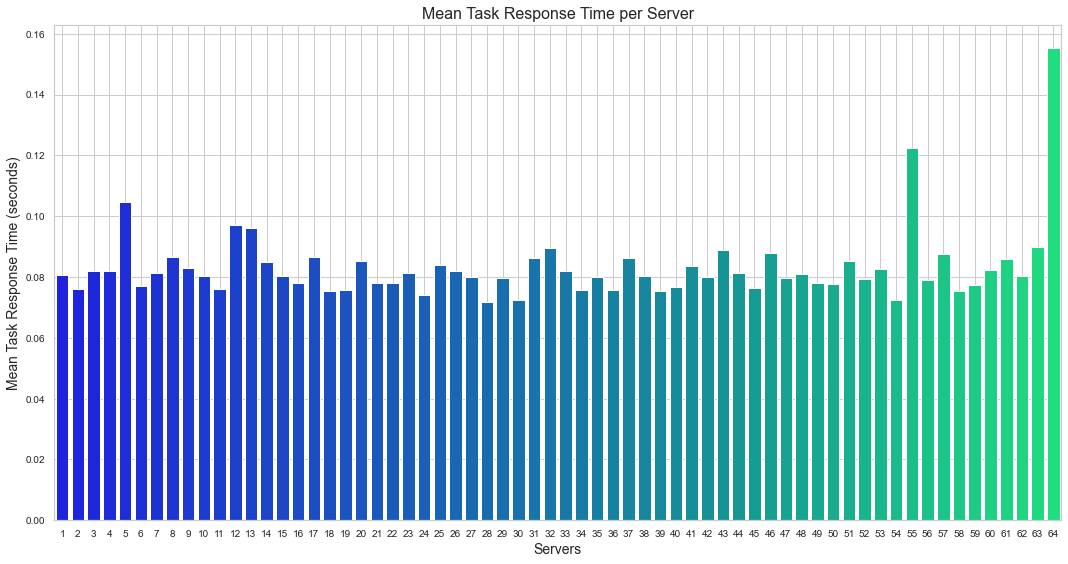

In [17]:
# Compute the mean server response times
mean_server_response_times = {server: np.mean(times) if times else float('nan') for server, times in server_response_times.items()}

# Extract server names and response times
servers = list(mean_server_response_times.keys())
response_times = list(mean_server_response_times.values())

# Set style
sns.set(style="whitegrid")

# Plotting the data
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=servers, y=response_times, palette="winter", ax=ax)

# Set plot aesthetics
ax.set_xlabel('Servers', fontsize=14)
ax.set_ylabel('Mean Task Response Time (seconds)', fontsize=14)
ax.set_title('Mean Task Response Time per Server', fontsize=16)

# Customize tick labels and tick parameters
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.grid(True)

# Adjust spacing and margins
fig.tight_layout()

# Save or display the plot
plt.show()

Let's see if the tasks have been nicely distributed over the 64 servers:

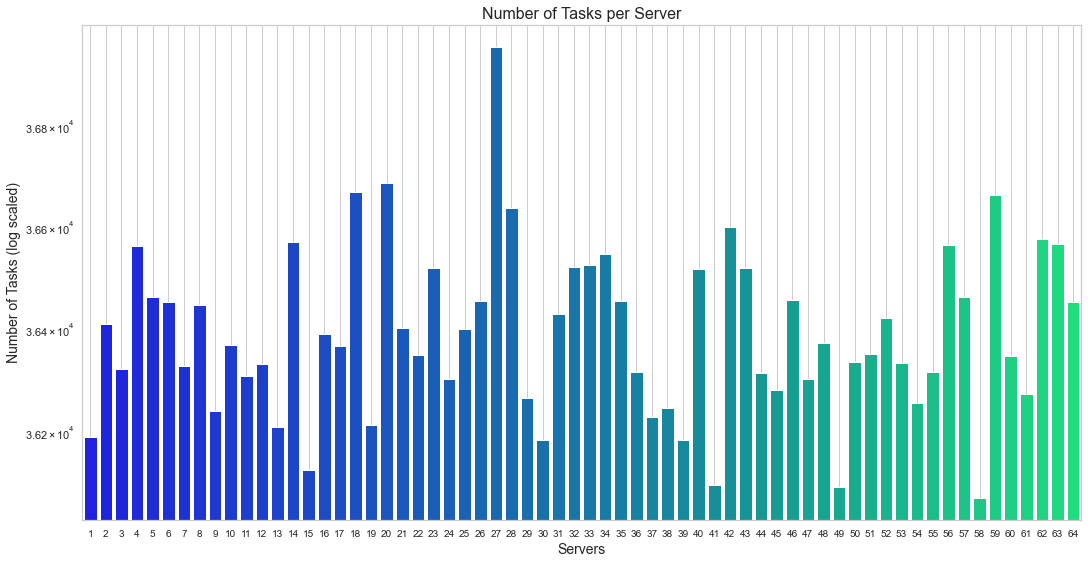

In [18]:
# Compute the number of tasks per server
mean_server_response_times = {server: len(times) if times else float('nan') for server, times in server_response_times.items()}

# Extract server names and number of tasks
servers = list(mean_server_response_times.keys())
response_times = list(mean_server_response_times.values())

# Set style
sns.set(style="whitegrid")

# Plotting the data
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=servers, y=response_times, palette="winter", ax=ax)

# Set plot aesthetics
ax.set_xlabel('Servers', fontsize=14)
ax.set_ylabel('Number of Tasks (log scaled)', fontsize=14)
ax.set_title('Number of Tasks per Server', fontsize=16)

# Customize tick labels and tick parameters
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.grid(True)

# Adjust spacing and margins
fig.tight_layout()

plt.yscale("log")

# Save or display the plot
plt.show()

A few checks that no task has been left unprocessed:

In [19]:
# Check that there are no tasks left
all_tasks = []

for i in range(1, 65):
    all_tasks.append(len(custom_server_status[i]['tasks']))
    
missing_tasks = len(task_queue)

if missing_tasks != sum(all_tasks):
    raise ValueError("Tasks not completely processed")

missing_tasks

0

In [20]:
# Check that there are no tasks left
processed_tasks = sum([len(x) for x in custom_task_service_times.values()])

processed_tasks

2329133

In [21]:
# Check that there are no tasks left
processed_tasks + missing_tasks == len(df)

True

In [22]:
# Check that there are no tasks left
overall_tasks_completed = processed_tasks / len(df)

overall_tasks_completed

1.0

Let's check if the mean service time is consistent with the average CPU requirement observed during the EDA. We find out that the two values are basically identical:

In [23]:
avg_service_time = np.mean([x for y in custom_task_service_times.values() for x in y])

'{:.20f}'.format(abs((avg_service_time * 0.1 * 1000) - df['CPU'].mean()))

'0.00000000000000177636'

Below we tweak our custom model by replacing the LLF and the SRTF algorithms with the LWL and the FCFS algorithms. We will then compare their results.

In [24]:
# Initialize a dictionary to store the server status for each server
baseline_server_status = {i: {'unfinished_work': 0, 'first_arrival_time': 0, 'last_arrival_time': 0, 'memory': GNMU, 'cpu': GNCU, 'tasks': []} for i in range(1, N + 1)}

# Initialize a dictionary to store the task service times
baseline_task_service_times = {}

# Initialize a dictionary to store the task response times
baseline_task_response_times = {}

# Initialize a dictionary to store the amount of messages of each task
baseline_task_messaging_load = {}

# Initialize a dictionary to store the job response times for each server
server_response_times = {i: [] for i in range(1, N + 1)}

# Initialize a task queue
task_queue = deque()

def choose_server(servers_loads):  
    min_value = min(servers_loads.values())
    min_keys = [key for key, value in servers_loads.items() if value == min_value]
    
    chosen_server = np.random.choice(min_keys)
    
    return chosen_server

def scheduling_algorithm(job_id, task_id, arrival_time, cpu, memory, chosen_server):
    
    # FCFS scheduling algorithm to schedule the task on the chosen server
    
    # convert from microseconds to seconds
    arrival_time = arrival_time / 1000000
    
    service_time = (cpu / mu) / 1000
    
    if job_id not in baseline_task_service_times:
        baseline_task_service_times[job_id] = []
        baseline_task_response_times[job_id] = []
        
    if not baseline_server_status[chosen_server]['first_arrival_time']:
        baseline_server_status[chosen_server]['first_arrival_time'] = arrival_time

    baseline_server_status[chosen_server]['unfinished_work'] += service_time
    baseline_server_status[chosen_server]['memory'] -= memory
    baseline_server_status[chosen_server]['cpu'] -= cpu
    baseline_server_status[chosen_server]['last_arrival_time'] = arrival_time + service_time
    baseline_server_status[chosen_server]['tasks'].append([arrival_time, service_time, memory])
    
    finish_time = max(arrival_time, baseline_server_status[chosen_server]['last_arrival_time']) + service_time

    baseline_task_service_times[job_id].append(service_time)
    
    baseline_task_response_times[job_id].append(finish_time - arrival_time)
    
    server_response_times[chosen_server].append(finish_time - arrival_time)
    
    baseline_task_messaging_load[job_id][task_id] += 1

    baseline_server_status[chosen_server]['last_arrival_time'] = finish_time
    
    for server in baseline_server_status.values():
        server['tasks'] = [task for task in server['tasks'] if task[0] + task[1] > arrival_time]
        server['unfinished_work'] = sum(task[1] for task in server['tasks'])
        server['memory'] = GNMU - sum(task[2] for task in server['tasks'])
        server['cpu'] = GNCU - sum(task[1] * mu for task in server['tasks'])

for index, row in tqdm(df.iterrows()):
    job_id, task_id, arrival_time, cpu, memory = row['Job_ID'], row['Task_ID'], row['Arrival_Time'], row['CPU'], row['Memory']
    
    if job_id not in baseline_task_messaging_load:
        baseline_task_messaging_load[job_id] = {}
        
    if task_id not in baseline_task_messaging_load[job_id]:
        baseline_task_messaging_load[job_id][task_id] = 0
    
    # LWL dispatching algorithm to choose a server for the task
    servers_loads = {server_id: server['unfinished_work'] for server_id, server in baseline_server_status.items() if server['memory'] >= memory and server['cpu'] >= cpu}
    
    baseline_task_messaging_load[job_id][task_id] += 2 * N
    
    if not servers_loads:
        task_queue.append([job_id, task_id, arrival_time, cpu, memory])
        continue
    
    chosen_server = choose_server(servers_loads)
    
    baseline_task_messaging_load[job_id][task_id] += 1
    
    scheduling_algorithm(job_id, task_id, arrival_time, cpu, memory, chosen_server)

    while task_queue:
        job_id, task_id, arrival_time, cpu, memory = task_queue[0]

        servers_loads = {server_id: server['unfinished_work'] for server_id, server in baseline_server_status.items() if server['memory'] >= memory and server['cpu'] >= cpu}
        
        baseline_task_messaging_load[job_id][task_id] += 2 * N
        
        if not servers_loads:
            break
            
        chosen_server = choose_server(servers_loads)
        
        baseline_task_messaging_load[job_id][task_id] += 1
        
        scheduling_algorithm(job_id, task_id, arrival_time, cpu, memory, chosen_server)
        
        task_queue.popleft()

0it [00:00, ?it/s]

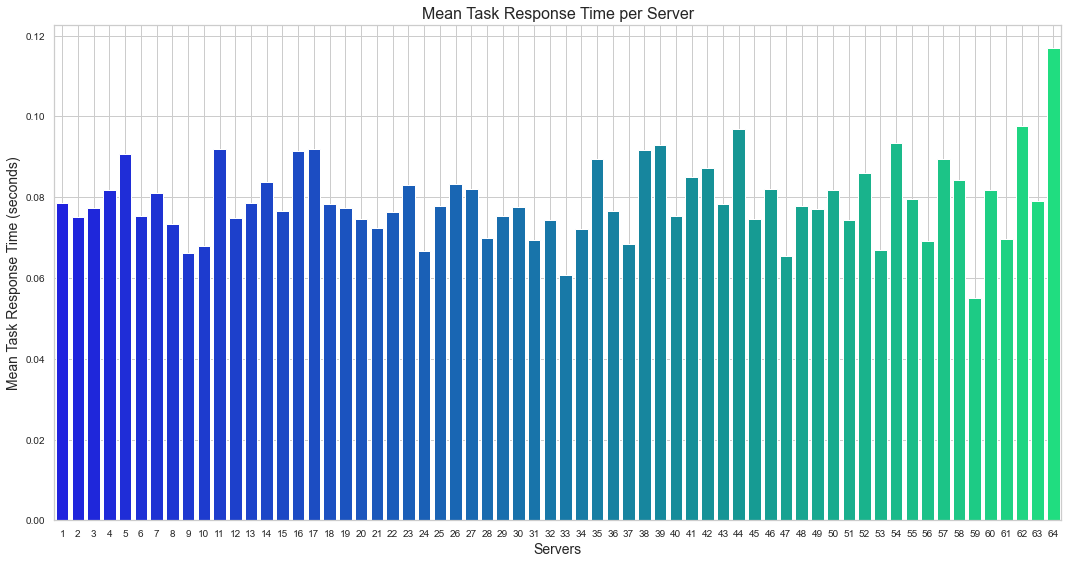

In [25]:
# Compute the mean server response times
mean_server_response_times = {server: np.mean(times) if times else float('nan') for server, times in server_response_times.items()}

# Extract server names and response times
servers = list(mean_server_response_times.keys())
response_times = list(mean_server_response_times.values())

# Set style
sns.set(style="whitegrid")

# Plotting the data
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=servers, y=response_times, palette="winter", ax=ax)

# Set plot aesthetics
ax.set_xlabel('Servers', fontsize=14)
ax.set_ylabel('Mean Task Response Time (seconds)', fontsize=14)
ax.set_title('Mean Task Response Time per Server', fontsize=16)

# Customize tick labels and tick parameters
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.grid(True)

# Adjust spacing and margins
fig.tight_layout()

# Save or display the plot
plt.show()

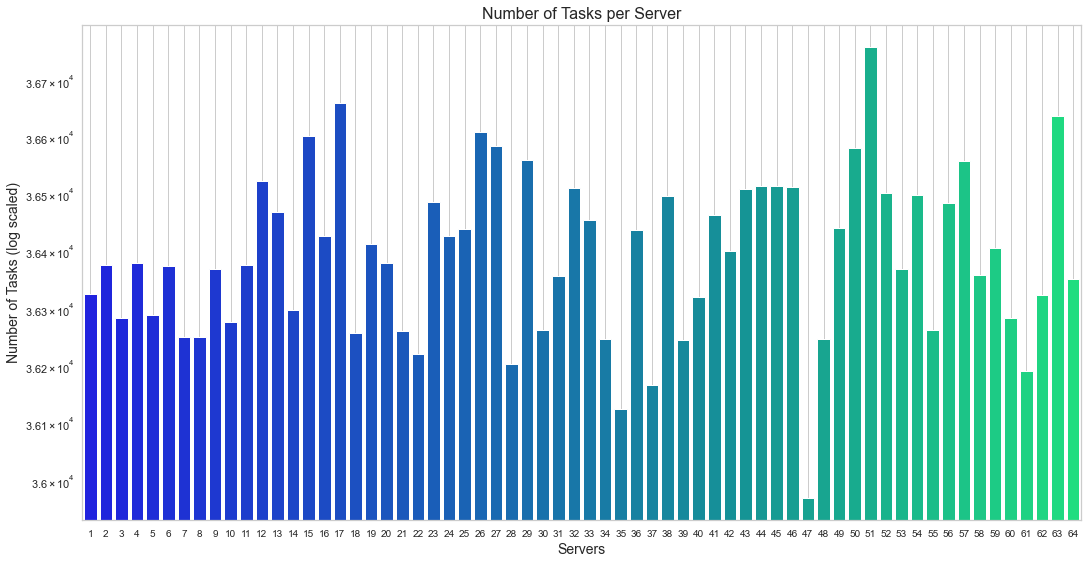

In [26]:
# Compute the number of tasks per server
mean_server_response_times = {server: len(times) if times else float('nan') for server, times in server_response_times.items()}

# Extract server names and number of tasks
servers = list(mean_server_response_times.keys())
response_times = list(mean_server_response_times.values())

# Set style
sns.set(style="whitegrid")

# Plotting the data
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=servers, y=response_times, palette="winter", ax=ax)

# Set plot aesthetics
ax.set_xlabel('Servers', fontsize=14)
ax.set_ylabel('Number of Tasks (log scaled)', fontsize=14)
ax.set_title('Number of Tasks per Server', fontsize=16)

# Customize tick labels and tick parameters
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.grid(True)

# Adjust spacing and margins
fig.tight_layout()

plt.yscale("log")

# Save or display the plot
plt.show()

Again, we make sure that no task has been left unprocessed:

In [27]:
# Check that there are no tasks left
all_tasks = []

for i in range(1, 65):
    all_tasks.append(len(baseline_server_status[i]['tasks']))
    
missing_tasks = len(task_queue)

if missing_tasks != sum(all_tasks):
    raise ValueError("Tasks not completely processed")

missing_tasks

0

In [28]:
# Check that there are no tasks left
processed_tasks = sum([len(x) for x in baseline_task_service_times.values()])

processed_tasks

2329133

In [29]:
# Check that there are no tasks left
processed_tasks + missing_tasks == len(df)

True

In [30]:
# Check that there are no tasks left
overall_tasks_completed = processed_tasks / len(df)

overall_tasks_completed

1.0

### 3. Performance evaluation

We can use the list of all the job response times to compute the mean response time $\bar{R}$:

In [31]:
custom_job_response_times = [np.sum(x) for x in custom_task_response_times.values()]
baseline_job_response_times = [np.sum(x) for x in baseline_task_response_times.values()]

custom_mean_job_response_time = np.mean(custom_job_response_times)
baseline_mean_job_response_time = np.mean(baseline_job_response_times)

print(f'Custom Mean Job Response Time: {format_timespan(custom_mean_job_response_time, detailed=True)}')
print(f'Baseline Mean Job Response Time: {format_timespan(baseline_mean_job_response_time, detailed=True)}')

Custom Mean Job Response Time: 166 milliseconds, 687 microseconds and 431.68 nanoseconds
Baseline Mean Job Response Time: 158 milliseconds, 708 microseconds and 505.69 nanoseconds


In [33]:
custom_max_job_response_time = np.max(custom_job_response_times)
baseline_max_job_response_time = np.max(baseline_job_response_times)

print(f'Custom Maximum Job Response Time: {format_timespan(custom_max_job_response_time)}')
print(f'Baseline Maximum Job Response Time: {format_timespan(baseline_max_job_response_time)}')

Custom Maximum Job Response Time: 13 hours, 14 minutes and 2.81 seconds
Baseline Maximum Job Response Time: 6 hours, 34 minutes and 55.34 seconds


Now we compute the Job slowdown $\bar{S}$, which is obtained by averaging the slowdown values of all jobs

In [34]:
custom_job_service_times = [np.sum(x) for x in custom_task_service_times.values()]
baseline_job_service_times = [np.sum(x) for x in baseline_task_service_times.values()]

custom_job_slowdowns = [(x / y) if y != 0 else 0 for x, y in zip(custom_job_response_times, custom_job_service_times)]
baseline_job_slowdowns = [(x / y) if y != 0 else 0 for x, y in zip(baseline_job_response_times, baseline_job_service_times)]

print(f'Custom Mean Job Slowdown: {round(np.mean(custom_job_slowdowns))}')
print(f'Baseline Mean Job Slowdown: {round(np.mean(baseline_job_slowdowns))}')

Custom Mean Job Slowdown: 50
Baseline Mean Job Slowdown: 2


Let's calculate the Utilization Coefficient of each server, that is, $\rho_{k}$

In [35]:
rho = [
    [k, 
     (custom_server_status[k]['last_arrival_time'] - custom_server_status[k]['first_arrival_time']) * 1000000,
     (baseline_server_status[k]['last_arrival_time'] - baseline_server_status[k]['first_arrival_time']) * 1000000
    ] 
    for k in range(1, N + 1)
]

rho_df = pd.DataFrame(rho, columns=['Server', 'Custom Rho', 'Baseline Rho'])
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
rho_df

,Server,Custom Rho,Baseline Rho
0,1,2677951522059.210,2678307120492.171
1,2,2677420930811.359,2677577163965.803
2,3,2678091311350.542,2678084492360.084
3,4,2678298004586.569,2678296324586.095
4,5,2677740070748.267,2678271235910.984
5,6,2678104401317.208,2678298004592.138
6,7,2678060786078.000,2677652474994.971
7,8,2678021138565.218,2678058365983.436
8,9,2678018010780.216,2678263154032.967
9,10,2677677563606.271,2678249792813.334


In [36]:
custom_mean_utilization_coefficient = np.mean(rho_df['Custom Rho'])
baseline_mean_utilization_coefficient = np.mean(rho_df['Baseline Rho'])

print(f'Custom Mean Utilization Coefficient:\n{format_timespan(custom_mean_utilization_coefficient / 1000000, detailed=True)}')
print('')
print(f'Baseline Mean Utilization Coefficient:\n{format_timespan(baseline_mean_utilization_coefficient / 1000000, detailed=True)}')

Custom Mean Utilization Coefficient:
4 weeks, 2 days, 23 hours, 53 minutes, 11 seconds, 524 milliseconds, 764 microseconds and 264 nanoseconds

Baseline Mean Utilization Coefficient:
4 weeks, 2 days, 23 hours, 52 minutes, 53 seconds, 54 milliseconds, 220 microseconds and 34.7 nanoseconds


The same values, this time in microseconds:

In [37]:
print(f'Custom Mean Utilization Coefficient: {round(custom_mean_utilization_coefficient)} µs')
print(f'Baseline Mean Utilization Coefficient: {round(baseline_mean_utilization_coefficient)} µs')

Custom Mean Utilization Coefficient: 2677991524764 µs
Baseline Mean Utilization Coefficient: 2677973054220 µs


The same values, this time in days:

In [38]:
print(f'Custom Mean Utilization Coefficient: {custom_mean_utilization_coefficient / 1000000 / 84600} days')
print(f'Baseline Mean Utilization Coefficient: {baseline_mean_utilization_coefficient / 1000000 / 84600} days')

Custom Mean Utilization Coefficient: 31.654746155605956 days
Baseline Mean Utilization Coefficient: 31.654527827659987 days


Eventually, we now want to calculate the mean message load $\bar{L}$:

In [39]:
custom_task_loads = [int(np.mean(list(x.values()))) for x in list(custom_task_messaging_load.values())]
baseline_task_loads = [int(np.mean(list(x.values()))) for x in list(baseline_task_messaging_load.values())]

print(f'Custom Average Messaging Load: {int(np.mean(custom_task_loads))}')
print(f'Baseline Average Messaging Load: {int(np.mean(baseline_task_loads))}')

Custom Average Messaging Load: 130
Baseline Average Messaging Load: 130


Unsurprisingly, we have that the average messaging load is equal to $130$, that is: $(N \times 2) + 2$, where $N = 64$. The fact that the result is exactly $(N \times 2) + 2$, means that there was no need to put any task in the queue while distributing the workload.
Both our models need such load of messages.

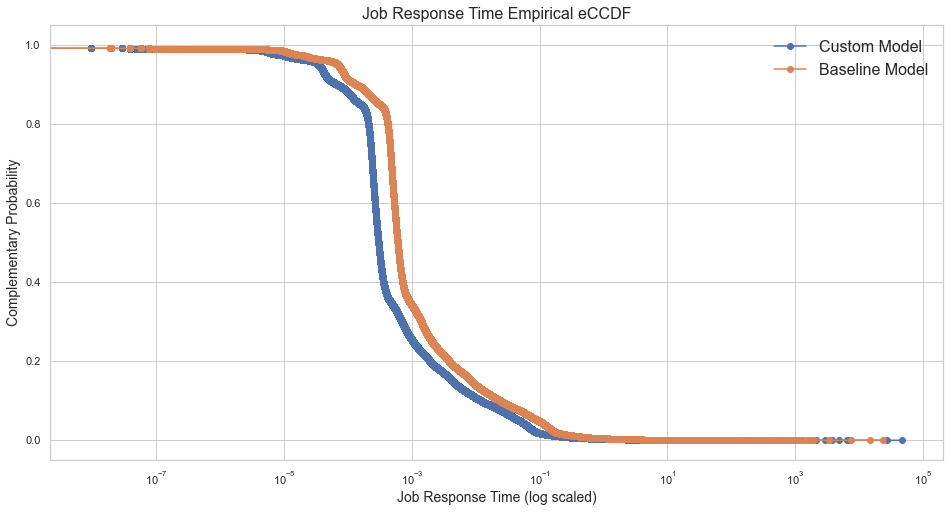

In [40]:
custom_sorted_data = np.sort(custom_job_response_times)
custom_ranks = np.arange(1, len(custom_sorted_data) + 1)
custom_probabilities = 1 - (custom_ranks / len(custom_sorted_data))

baseline_sorted_data = np.sort(baseline_job_response_times)
baseline_ranks = np.arange(1, len(baseline_sorted_data) + 1)
baseline_probabilities = 1 - (baseline_ranks / len(baseline_sorted_data))

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(custom_sorted_data, custom_probabilities, marker='o', label='Custom Model')
ax.plot(baseline_sorted_data, baseline_probabilities, marker='o', label='Baseline Model')

ax.legend(fontsize=16, fancybox=True, facecolor='none')

plt.xscale('log')
plt.xlabel("Job Response Time (log scaled)", fontsize=14)
plt.ylabel('Complementary Probability', fontsize=14)
plt.title('Job Response Time Empirical eCCDF', fontsize=16)

plt.grid(True)

plt.show()

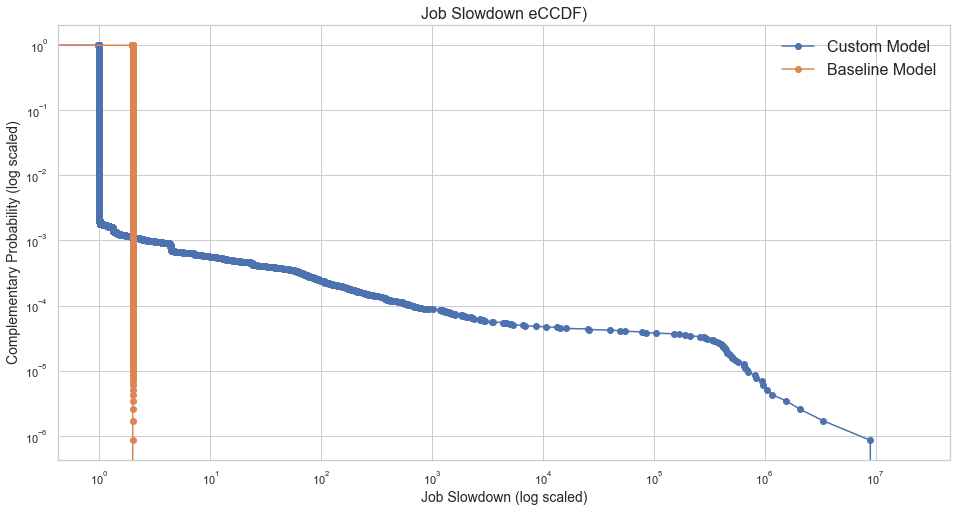

In [41]:
custom_sorted_data = np.sort(custom_job_slowdowns)
custom_ranks = np.arange(1, len(custom_sorted_data) + 1)
custom_probabilities = 1 - (custom_ranks / len(custom_sorted_data))

baseline_sorted_data = np.sort(baseline_job_slowdowns)
baseline_ranks = np.arange(1, len(baseline_sorted_data) + 1)
baseline_probabilities = 1 - (baseline_ranks / len(baseline_sorted_data))

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(custom_sorted_data, custom_probabilities, marker='o', label='Custom Model')
ax.plot(baseline_sorted_data, baseline_probabilities, marker='o', label='Baseline Model')

ax.legend(fontsize=16, fancybox=True, facecolor='none')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Job Slowdown (log scaled)", fontsize=14)
plt.ylabel('Complementary Probability (log scaled)', fontsize=14)
plt.title('Job Slowdown eCCDF)', fontsize=16)

plt.grid(True)

plt.show()